<a href="https://colab.research.google.com/github/msdkang/Waterway_Traffic_Demand_Prediction/blob/main/Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

Required Functions

In [40]:
def divide_dataset(data, train_share=0.8):
    """
    it splits timeserise data into train and test sets
    
    Argument:
    data -- dataframe of timeseries data
    train_share -- a decimal value between 0 to 1 showing the share of train sets. The default value is 0.8

    Returns:
    array of train_set
    array of test_set
    """ 
    cut_point = int(len(data)*train_share)
    train_set = data.iloc[:cut_point+1]
    test_set = data.iloc[cut_point:]
    return train_set, test_set
  

  
def historical_plot(df):
    """
    it plots the timeseries data for different columns 
    
    Argument:
    df -- dataframe of timeseries data

    Returns:
    
    """ 
    
    plotdata = df.copy()
    
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15, 9))
    locator = mdates.AutoDateLocator(minticks=20, maxticks=40)
    formatter = mdates.ConciseDateFormatter(locator)
    ax3.xaxis.set_major_locator(locator)
    ax3.xaxis.set_major_formatter(formatter)
    
    ax1.plot( 'date_interval', 'Inbound', data=plotdata, color='red', linewidth=1.25, label='Inbound')
    ax2.plot( 'date_interval', 'Outbound', data=plotdata, color='blue', linewidth=1.25, label='Outbound')
    ax3.plot( 'date_interval', 'Shift', data=plotdata, color='gray', linewidth=1.25, label='shift')
    
    ax1.set_xlim((np.datetime64('2018-01-01'), np.datetime64('2020-06-30')))  
    ax1.set_ylim((0,80))
    
    ax2.set_xlim((np.datetime64('2018-01-01'), np.datetime64('2020-06-30')))  
    ax2.set_ylim((0,80))
    
    ax3.set_xlim((np.datetime64('2018-01-01'), np.datetime64('2020-06-30')))  
    ax3.set_ylim((0,80))

    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    ax1.legend()   
    ax2.legend()   
    ax3.legend()
    ax1.set_title("Job Activities")
    ax1.set_ylabel("No. of jobs")
    ax2.set_ylabel("No. of jobs")
    ax3.set_ylabel("No. of jobs")
    ax3.set_xlabel("date")
    
    plt.show()

def plot_results(data_train, data_test, date_col, feature_a, feature_p='pred', start_date = np.datetime64('2020-03-01'), end_date = np.datetime64('2020-06-30')):     
    """
    it plots the model results for train and test data sets and show models performance metrics including RMSE, MAE, MAPE, R_squared 
    
    Argument:
    data_train -- dataframe of atcual and predicted values at each timesteps for train data set: columns:{time, actual y, predicted y}
    data_test -- dataframe of atcual and predicted values at each timesteps for test data set: columns:{time, actual y, predicted y}

    feature_a -- column name where atcual value are located
    feature_b -- column name where predicted value are located. default value is 'pred'
    start_date -- start date for the x axis of the plot
    end_date -- end date for the x axis of the plot 

    Returns:
  
    """ 
    data_train[date_col] = np.array(data_train[date_col]).astype('datetime64[ns]')
    data_test[date_col] = np.array(data_test[date_col]).astype('datetime64[ns]')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    
    ax.plot(date_col, feature_a, data=data_train, color='red', linewidth=1.25, label='actual(train)')
    ax.plot(date_col, feature_p, data=data_train, color='blue', linewidth=1.25, label='prediction(train)')
    ax.plot(date_col, feature_a, data=data_test, linestyle= '--', color='red', linewidth=1.25, label='actual(test)')
    ax.plot(date_col, feature_p, data=data_test, linestyle= '--', color='blue', linewidth=1.25, label='prediction(test)')
                
    ax.set_xlim((start_date, end_date))  
    ax.set_ylim((0))
      
    plt.title("Actual and Prediction Values")
    plt.xlabel("date")
    plt.ylabel(feature_a)
    plt.legend() 
    
    plt.show()
    
    
    n_train =len(data_train) 
    mse_train,mae_train, mape_train, r2_train= mean_sa_error(data_train)

    n_test =len(data_test) 
    mse_test,mae_test, mape_test, r2_test = mean_sa_error(data_test)
        
    results = {'sample size': [n_train, n_test],
               'RMSE': [mse_train, mse_test],
               'MAE': [mae_train, mae_test],
               'MAPE': [mape_train, mape_test],
               'R-squared':[r2_train, r2_test]}
    
    
    header = ['Train set', 'Test set']
    row_format ="{:<25}" * (len(header) + 1)
    print(row_format.format("metrics", *header))
    print("----------------------"* (len(header) + 1))
    for row in results:
        print(row_format.format(row,*results[row]))
    

def mean_sa_error(pred): 
    """
    it calculates the model performance metrics including RMSE, MAE, MAPE, R_squared 
    
    Argument:
    pred -- dataframe of atcual and predicted values at each timesteps: columns:{time, actual y, predicted y}

    Returns:
    rmse -- value of RMSE
    mae -- value of MAE
    mape -- value of MAPE
    rsqr -- value of R-quared
  
    """ 
    e= pred.iloc[:,1].values - pred.iloc[:,2].values
    rmse = np.sqrt(np.nanmean(e**2))
    mae = np.nanmean(np.abs(e))
    c = pred.iloc[:,1].values
    c[c==0] = 0.001
    mape = np.nanmean(np.abs(e / c)) * 100
        
    y = pred.iloc[:,1].values
    y_hat = pred.iloc[:,2].values
    y_bar = np.nanmean(y)
    SST = np.nansum((y - y_bar)**2)
    SSR = np.nansum((y_hat - y)**2)
    rsqr = 1-SSR/SST

    return rmse, mae, mape, rsqr



Load data and create train and test sets

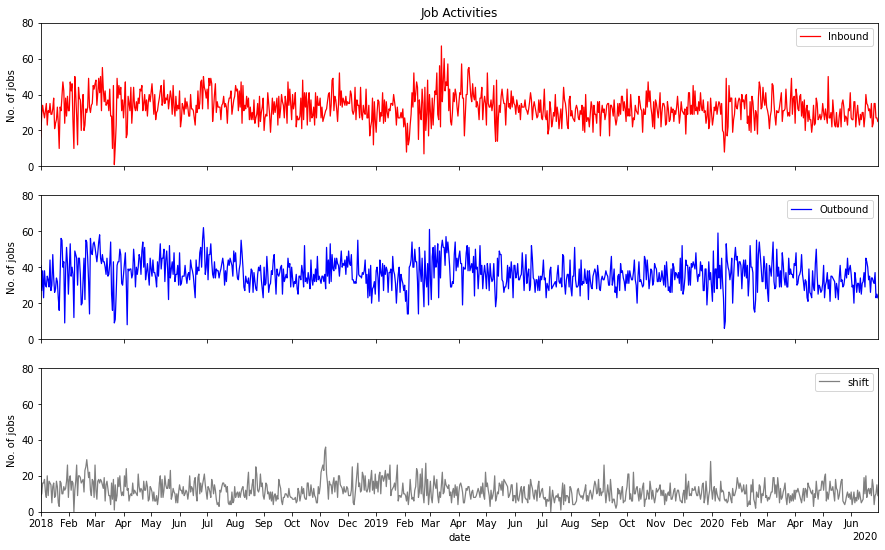

In [35]:
df = pd.read_csv('daily_data.csv')


feature = 'Inbound'
date_col = 'date_interval'
x =df[feature].to_numpy()
dates = np.array(df[date_col].values).astype(np.datetime64)
df[date_col] = dates
series = pd.Series(x, index=dates)

n_test = 7 # 7days
train_share = (len(df)-n_test)/len(df)
train_df, test_df = divide_dataset(df,train_share)

train_series = series[:-n_test+1]
test_series = series[-n_test:]

historical_plot(df)

**Baseline Timeseries Models**

AutoRegressive Model (AR)

1.   *tune AR parameter (p)*


AR lag= 1 RMSE=8.072 MAPE=34.318 RMSE(val)=5.999 MAPE(val)=14.823
AR lag= 2 RMSE=7.980 MAPE=32.975 RMSE(val)=5.828 MAPE(val)=13.905
AR lag= 3 RMSE=7.960 MAPE=32.931 RMSE(val)=5.854 MAPE(val)=14.482
AR lag= 4 RMSE=7.823 MAPE=32.138 RMSE(val)=6.675 MAPE(val)=15.981
AR lag= 5 RMSE=7.837 MAPE=32.197 RMSE(val)=6.708 MAPE(val)=16.027
AR lag= 6 RMSE=7.838 MAPE=32.218 RMSE(val)=6.859 MAPE(val)=16.664
AR lag= 7 RMSE=7.849 MAPE=32.249 RMSE(val)=6.882 MAPE(val)=17.079
AR lag= 8 RMSE=7.839 MAPE=32.301 RMSE(val)=6.510 MAPE(val)=16.605
AR lag= 9 RMSE=7.833 MAPE=32.269 RMSE(val)=6.605 MAPE(val)=16.907
AR lag= 10 RMSE=7.848 MAPE=32.419 RMSE(val)=6.597 MAPE(val)=16.873
AR lag= 11 RMSE=7.830 MAPE=32.334 RMSE(val)=6.350 MAPE(val)=16.121
AR lag= 12 RMSE=7.842 MAPE=32.491 RMSE(val)=6.321 MAPE(val)=15.951
AR lag= 13 RMSE=7.840 MAPE=32.184 RMSE(val)=6.256 MAPE(val)=15.686
AR lag= 14 RMSE=7.849 MAPE=32.230 RMSE(val)=6.270 MAPE(val)=15.793
AR lag= 15 RMSE=7.863 MAPE=32.274 RMSE(val)=6.309 MAPE(val)=15.861
AR l

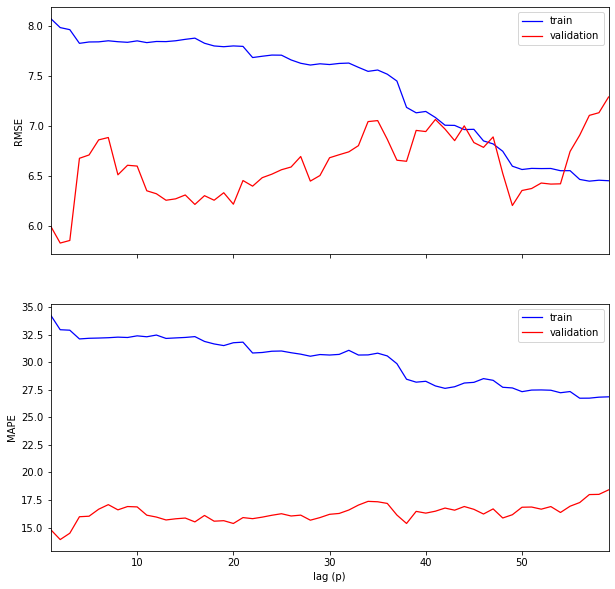

In [42]:
from statsmodels.tsa.ar_model import AutoReg

def train_AR(train_series, test_series, p, disp_result= True, return_mse=False):
    """
    it trains an AR model on give train value and checks the model performance on test set.
    
    Argument:
    train_series -- series of train value
    test_series -- series of test value
    p -- the model parameter (lag)
    disp_result -- the boolean value to whether show the actual and predicted values
    return_mse -- the boolean value to whether return the model performance 

    Returns:
    mse_tr -- value of RMSE for train set
    mse_ts -- value of RMSE for test set
    mape_tr -- value of MAPE for train set
    mape_ts -- value of MAPE for test set

    """ 
    history = [(float) (x) for x in train_series]       
    predictions = []
    for t in range(len(test_series)): 
        model = AutoReg(np.array(history).astype('float'), lags = p)
        model_fit = model.fit()
        output = model_fit.predict(len(history),len(history))
        yhat = output[0]
        predictions.append(yhat)
        obs = test_series[t]
        history.append(obs)
                
        if (disp_result):
            print('date=%s, predicted=%f, expected=%f' % (test_series.keys()[t].strftime("%m/%d/%Y"), yhat, obs))
            
    pred = pd.DataFrame({'date':test_series.keys(), 'actual_y':np.array(test_series),'pred_y': np.array(predictions)})

    model = AutoReg(np.array(train_series).astype('float'), lags = p)
    model_fit = model.fit()
    predictions = model_fit.predict()
    
    train = pd.DataFrame({'date':train_series[p:].keys(), 'actual_y':np.array(train_series[p:]),'pred_y': np.array(predictions[p:])})

    if (return_mse):
        mse_tr, _, mape_tr,_ = mean_sa_error(train)
        mse_ts, _, mape_ts, _ = mean_sa_error(pred)
        return mse_tr, mape_tr,mse_ts, mape_ts
    else:
        last_date = np.array(pred['date']).astype('datetime64[D]').max()
        first_date = last_date - np.array(30).astype('timedelta64[D]')
        plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)



def tune_AR(series, p_values, val_n = 7, z_ratio = 0.3):  
    """
    it tries different value of p to train AR model and plot the model performance
    
    Argument:
    series -- series of timeseries value
    p_values -- the array of given values for p
    val_n -- the size of validation set. the default value is 7
    z_ratio -- the ratio of data based on which it tunes the p values. the default value is 0.3

    Returns:
    plot of train and validation performance for different p values
    """ 

    scores_mse_tr = list()
    scores_mape_tr = list()
    scores_mse_ts = list()
    scores_mape_ts = list()
    n_val1 = (int) (len(series)*z_ratio)
    n_val2 = n_val1+val_n
    train_s = series[:n_val1]
    val_s = series[n_val1:n_val2]
    train_s.shape[0]
    p_values = np.array(p_values)
    p_values= p_values[(p_values<train_s.shape[0]/2)]
    
    for p in p_values:
        mse_tr,mape_tr,mse_ts,mape_ts = train_AR(train_s, val_s, p, False, True)

        scores_mse_tr.append(mse_tr)
        scores_mape_tr.append(mape_tr)
        
        scores_mse_ts.append(mse_ts)
        scores_mape_ts.append(mape_ts)
        
        print('AR lag= %s RMSE=%.3f MAPE=%.3f RMSE(val)=%.3f MAPE(val)=%.3f' % (p,mse_tr,mape_tr, mse_ts,mape_ts))
           
    # plot scores over window sizes values
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
    
    ax1.plot(p_values, scores_mse_tr, color='blue', linewidth=1.25, label='train')
    ax1.plot(p_values, scores_mse_ts, color='red', linewidth=1.25, label='validation')

    ax2.plot(p_values, scores_mape_tr, color='blue', linewidth=1.25, label='train')
    ax2.plot(p_values, scores_mape_ts, color='red', linewidth=1.25, label='validation')
  
    ax1.set_ylabel("RMSE")
    ax2.set_ylabel("MAPE")
    ax2.set_xlabel("lag (p)")

    ax1.set_xlim((p_values[0],p_values[-1]))
    ax2.set_xlim((p_values[0],p_values[-1]))
    ax1.legend()   
    ax2.legend()
    
    plt.setp(ax1.get_xticklabels(), visible=False)
        
    plt.show()



tune_AR(train_series, p_values=range(1,60,1), val_n=7)

2.   *train AR model based on given p. (p=12)*

date=06/24/2020, predicted=31.797813, expected=22.000000
date=06/25/2020, predicted=30.968536, expected=24.000000
date=06/26/2020, predicted=29.457302, expected=35.000000
date=06/27/2020, predicted=29.034591, expected=35.000000
date=06/28/2020, predicted=31.102502, expected=27.000000
date=06/29/2020, predicted=31.799781, expected=27.000000
date=06/30/2020, predicted=31.126931, expected=25.000000


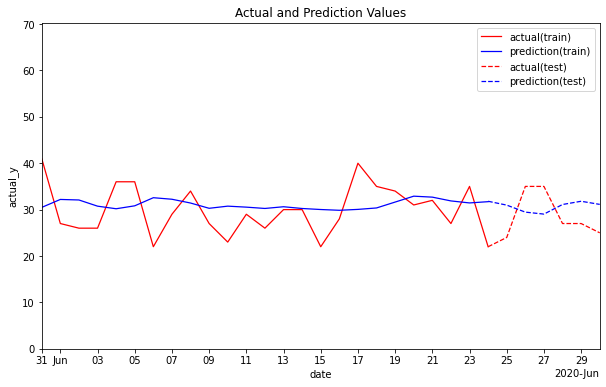

metrics                  Train set                Test set                 
------------------------------------------------------------------
sample size              893                      7                        
RMSE                     7.593559441469439        6.417308541127858        
MAE                      5.864097976364042        6.186238495880032        
MAPE                     24.126816059436603       23.418646758575925       
R-squared                0.08314112507385318      -0.7921053256568342      


In [41]:
p=12
train_AR(train_series, test_series, p, disp_result= True, return_mse=False)

3.   *K-fold on AR model.

In [43]:
k=5
n_validation = 7

data_array = train_series.copy()
cut_point = (int)(data_array.shape[0]/k)
data_array = data_array[0:cut_point*k]
for i in range(k):
    train_set = data_array[:(i+1)*cut_point-n_validation]
    validation_set = data_array[(i+1)*cut_point-n_validation:(i+1)*cut_point]  
    mse_tr,mape_tr,mse_ts,mape_ts = train_AR(train_set, validation_set, p, False, True)

    print('AR fold= %s RMSE=%.3f MAPE=%.3f RMSE(val)=%.3f MAPE(val)=%.3f' % (i+1,mse_tr,mape_tr, mse_ts,mape_ts))
        


AR fold= 1 RMSE=8.468 MAPE=42.268 RMSE(val)=8.415 MAPE(val)=14.762
AR fold= 2 RMSE=7.587 MAPE=28.344 RMSE(val)=9.199 MAPE(val)=34.371
AR fold= 3 RMSE=8.142 MAPE=27.719 RMSE(val)=5.603 MAPE(val)=16.929
AR fold= 4 RMSE=7.719 MAPE=25.073 RMSE(val)=3.588 MAPE(val)=8.965
AR fold= 5 RMSE=7.612 MAPE=24.216 RMSE(val)=4.778 MAPE(val)=11.245


Moving Average Model (MA)


1.   *tune MA parameter (q)*

In [44]:
from statsmodels.tsa.arima.model import ARIMA

def train_MA(train_series, test_series, q, disp_result= True, return_mse=False,  is_hourly=False):
    history = [(float) (x) for x in train_series]       
    predictions = []
    for t in range(len(test_series)): 
        model = ARIMA(np.array(history).astype('float'), order=(0, 0, q))
        model_fit = model.fit(cov_type= 'none', low_memory=True)
        output = model_fit.predict(len(history),len(history))
        yhat = output[0]
        predictions.append(yhat)
        obs = test_series[t]
        history.append(obs)
                
        if (disp_result):
            print('date=%s, predicted=%f, expected=%f' % (test_series.keys()[t].strftime("%m/%d/%Y"), yhat, obs))
            
    pred = pd.DataFrame({'date':test_series.keys(), 'actual_y':np.array(test_series),'pred_y': np.array(predictions)})

    model = ARIMA(np.array(train_series).astype('float'), order=(0, 0, q))
    model_fit = model.fit(cov_type= 'none', low_memory=True)
    predictions = model_fit.predict()
    
    train = pd.DataFrame({'date':train_series.keys(), 'actual_y':np.array(train_series),'pred_y': np.array(predictions)})

    if (return_mse):
        mse_tr, _, mape_tr,_ = mean_sa_error(train)
        mse_ts, _, mape_ts, _ = mean_sa_error(pred)
        return mse_tr, mape_tr,mse_ts, mape_ts
    else:
        last_date = np.array(pred['date']).astype('datetime64[D]').max()
        first_date = last_date - np.array(30).astype('timedelta64[D]')
        plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)
        if is_hourly:
            train['date'] = np.array(train['date']).astype('datetime64[D]')
            train = train.groupby('date').agg({'actual_y':'sum','pred_y':'sum'}).reset_index()
        
            pred['date'] = np.array(pred['date']).astype('datetime64[D]')
            pred = pred.groupby('date').agg({'actual_y':'sum','pred_y':'sum'}).reset_index()
            plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)


def tune_MA(series, q_values, val_n = 7, z_ratio = 0.5):    
    scores_mse_tr = list()
    scores_mape_tr = list()
    scores_mse_ts = list()
    scores_mape_ts = list()
    n_val1 = (int) (len(series)*z_ratio)
    n_val2 = n_val1+val_n
    train_s = series[:n_val1]
    val_s = series[n_val1:n_val2]
    for q in q_values:
        mse_tr,mape_tr,mse_ts,mape_ts = train_MA(train_s, val_s, q, False, True)
        
        scores_mse_tr.append(mse_tr)
        scores_mape_tr.append(mape_tr)
        
        scores_mse_ts.append(mse_ts)
        scores_mape_ts.append(mape_ts)
        
        print('MA window size (q)= %s RMSE=%.3f MAPE=%.3f RMSE(val)=%.3f MAPE(val)=%.3f' % (q,mse_tr,mape_tr, mse_ts,mape_ts))
           
    # plot scores over window sizes values
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
    
    ax1.plot(q_values, scores_mse_tr, color='blue', linewidth=1.25, label='train')
    ax1.plot(q_values, scores_mse_ts, color='red', linewidth=1.25, label='validation')

    ax2.plot(q_values, scores_mape_tr, color='blue', linewidth=1.25, label='train')
    ax2.plot(q_values, scores_mape_ts, color='red', linewidth=1.25, label='validation')
  
    ax1.set_ylabel("RMSE")
    ax2.set_ylabel("MAPE")
    ax2.set_xlabel("window size (q)")

    ax1.set_xlim((q_values[0],q_values[-1]))
    ax2.set_xlim((q_values[0],q_values[-1]))
    ax1.legend()   
    ax2.legend()
  


tune_MA(train_series, q_values=range(0,30,4), val_n=7)


2.   *train MA model considering q=7*

date=06/24/2020, predicted=31.490339, expected=22.000000
date=06/25/2020, predicted=30.153840, expected=24.000000
date=06/26/2020, predicted=29.108914, expected=35.000000
date=06/27/2020, predicted=29.906874, expected=35.000000
date=06/28/2020, predicted=31.695037, expected=27.000000
date=06/29/2020, predicted=32.174096, expected=27.000000
date=06/30/2020, predicted=31.179239, expected=25.000000


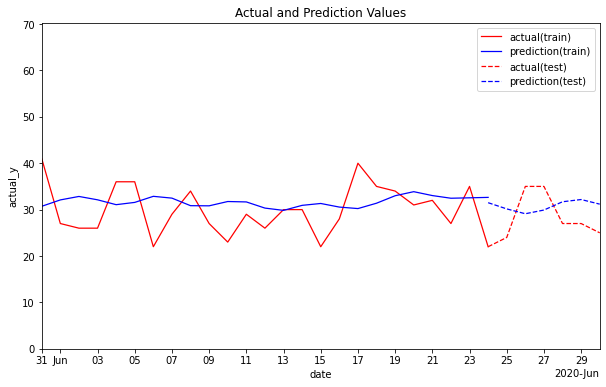

metrics                  Train set                Test set                 
------------------------------------------------------------------
sample size              907                      7                        
RMSE                     7.653877687675635        6.274423361917601        
MAE                      5.901565691832519        6.096680147232797        
MAPE                     24.194435181320763       23.061665766826096       
R-squared                0.06858899589385214      -0.7131891986716616      


In [45]:
q = 7
train_MA(train_series, test_series,q)

3.   *k-fold on MA model*

In [46]:
k=5
n_validation = 7

data_array = train_series.copy()
cut_point = (int)(data_array.shape[0]/k)
data_array = data_array[0:cut_point*k]
for i in range(k):
    train_set = data_array[:(i+1)*cut_point-n_validation]
    validation_set = data_array[(i+1)*cut_point-n_validation:(i+1)*cut_point]  
    mse_tr,mape_tr,mse_ts,mape_ts = train_MA(train_set, validation_set, q, False, True)

    print('MA fold= %s RMSE=%.3f MAPE=%.3f RMSE(val)=%.3f MAPE(val)=%.3f' % (i+1,mse_tr,mape_tr, mse_ts,mape_ts))

MA fold= 1 RMSE=8.502 MAPE=41.390 RMSE(val)=8.484 MAPE(val)=15.505
MA fold= 2 RMSE=7.687 MAPE=28.793 RMSE(val)=9.480 MAPE(val)=35.032
MA fold= 3 RMSE=8.229 MAPE=27.746 RMSE(val)=5.214 MAPE(val)=15.284
MA fold= 4 RMSE=7.790 MAPE=25.091 RMSE(val)=3.916 MAPE(val)=9.188
MA fold= 5 RMSE=7.672 MAPE=24.293 RMSE(val)=4.723 MAPE(val)=11.395


ARMA model


1.   *train ARMA*


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/24/2020, predicted=30.947969, expected=22.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/25/2020, predicted=31.390754, expected=24.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/26/2020, predicted=29.939230, expected=35.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/27/2020, predicted=28.281503, expected=35.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/28/2020, predicted=29.989543, expected=27.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/29/2020, predicted=30.036521, expected=27.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/30/2020, predicted=30.079712, expected=25.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


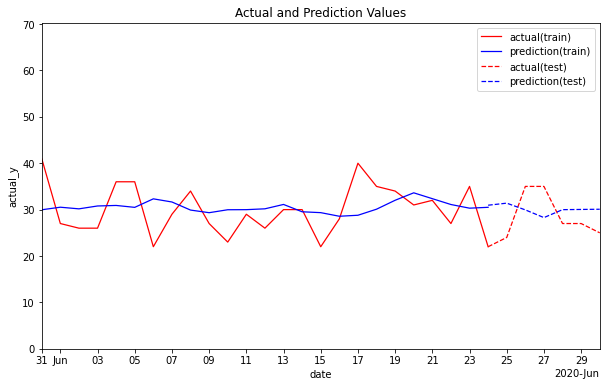

metrics                  Train set                Test set                 
------------------------------------------------------------------
sample size              907                      7                        
RMSE                     7.512904697967132        5.968970702357492        
MAE                      5.788964425017503        5.603395045473554        
MAPE                     24.1640312860919         21.10857764750782        
R-squared                0.10258342051563651      -0.5504457824462721      


In [47]:

def train_ARMA(train_series, test_series, p, q, disp_result= True, return_mse=False, is_hourly=False):
    history = [(float) (x) for x in train_series]       
    predictions = []
    for t in range(len(test_series)): 
        model = ARIMA(np.array(history).astype('float'), order=(p, 0, q))
        model_fit = model.fit(cov_type= 'none', low_memory=True)
        output = model_fit.predict(len(history),len(history))
        yhat = output[0]
        predictions.append(yhat)
        obs = test_series[t]
        history.append(obs)
                
        if (disp_result):
            print('date=%s, predicted=%f, expected=%f' % (test_series.keys()[t].strftime("%m/%d/%Y"), yhat, obs))
            
    pred = pd.DataFrame({'date':test_series.keys(), 'actual_y':np.array(test_series),'pred_y': np.array(predictions)})

    model = ARIMA(np.array(train_series).astype('float'), order=(p, 0, q))
    model_fit = model.fit(cov_type= 'none', low_memory=True)
    predictions = model_fit.predict()
    
    train = pd.DataFrame({'date':train_series.keys(), 'actual_y':np.array(train_series),'pred_y': np.array(predictions)})

    if (return_mse):
        mse_tr, _, mape_tr,_ = mean_sa_error(train)
        mse_ts, _, mape_ts, _ = mean_sa_error(pred)
        return mse_tr, mape_tr,mse_ts, mape_ts
    else:
        last_date = np.array(pred['date']).astype('datetime64[D]').max()
        first_date = last_date - np.array(30).astype('timedelta64[D]')
        plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)

        if is_hourly:
            train['date'] = np.array(train['date']).astype('datetime64[D]')
            train = train.groupby('date').agg({'actual_y':'sum','pred_y':'sum'}).reset_index()
        
            pred['date'] = np.array(pred['date']).astype('datetime64[D]')
            pred = pred.groupby('date').agg({'actual_y':'sum','pred_y':'sum'}).reset_index()
            plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)

train_ARMA(train_series, test_series,p, q)


2.   *k-fold on ARMA*

In [49]:
k=5
n_validation = 7

data_array = train_series.copy()
cut_point = (int)(data_array.shape[0]/k)
data_array = data_array[0:cut_point*k]
for i in range(k):
    train_set = data_array[:(i+1)*cut_point-n_validation]
    validation_set = data_array[(i+1)*cut_point-n_validation:(i+1)*cut_point]  
    mse_tr,mape_tr,mse_ts,mape_ts = train_ARMA(train_set, validation_set, p, q, False, True)

    print('ARMA fold= %s RMSE=%.3f MAPE=%.3f RMSE(val)=%.3f MAPE(val)=%.3f' % (i+1,mse_tr,mape_tr, mse_ts,mape_ts))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

ARMA fold= 1 RMSE=8.414 MAPE=40.086 RMSE(val)=8.514 MAPE(val)=14.542


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARMA fold= 2 RMSE=7.602 MAPE=28.473 RMSE(val)=9.035 MAPE(val)=33.906


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARMA fold= 3 RMSE=8.081 MAPE=27.541 RMSE(val)=5.600 MAPE(val)=16.821


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARMA fold= 4 RMSE=7.684 MAPE=24.965 RMSE(val)=3.967 MAPE(val)=8.800


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARMA fold= 5 RMSE=7.597 MAPE=24.285 RMSE(val)=5.008 MAPE(val)=10.674


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA


1.   *Train ARIMA*


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/24/2020, predicted=30.516083, expected=22.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/25/2020, predicted=30.169859, expected=24.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/26/2020, predicted=29.476664, expected=35.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


date=06/27/2020, predicted=28.692181, expected=35.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/28/2020, predicted=30.547452, expected=27.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/29/2020, predicted=30.116915, expected=27.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/30/2020, predicted=30.356022, expected=25.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


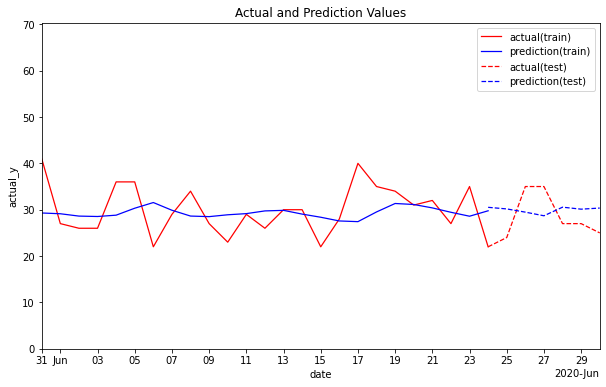

metrics                  Train set                Test set                 
------------------------------------------------------------------
sample size              907                      7                        
RMSE                     7.6408071088155          5.75541003220287         
MAE                      5.893256852073978        5.505355271652753        
MAPE                     24.666791675896473       20.618206620212174       
R-squared                0.0717674334378976       -0.44148533508018706     


In [48]:

def train_ARIMA(train_series, test_series, p, d, q, disp_result= True, return_mse=False, is_hourly=False):
    history = [(float) (x) for x in train_series]       
    predictions = []
    for t in range(len(test_series)): 
        model = ARIMA(np.array(history).astype('float'), order=(p, d, q))
        model_fit = model.fit(cov_type= 'none', low_memory=True)
        output = model_fit.predict(len(history),len(history))
        yhat = output[0]
        predictions.append(yhat)
        obs = test_series[t]
        history.append(obs)
                
        if (disp_result):
            print('date=%s, predicted=%f, expected=%f' % (test_series.keys()[t].strftime("%m/%d/%Y"), yhat, obs))
            
    pred = pd.DataFrame({'date':test_series.keys(), 'actual_y':np.array(test_series),'pred_y': np.array(predictions)})

    model = ARIMA(np.array(train_series).astype('float'), order=(p, d, q))
    model_fit = model.fit(cov_type= 'none', low_memory=True)
    predictions = model_fit.predict()
    
    train = pd.DataFrame({'date':train_series.keys(), 'actual_y':np.array(train_series),'pred_y': np.array(predictions)})

    if (return_mse):
        mse_tr, _, mape_tr,_ = mean_sa_error(train)
        mse_ts, _, mape_ts, _ = mean_sa_error(pred)
        return mse_tr, mape_tr,mse_ts, mape_ts
    else:
        last_date = np.array(pred['date']).astype('datetime64[D]').max()
        first_date = last_date - np.array(30).astype('timedelta64[D]')
        plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)
        if is_hourly:
            train['date'] = np.array(train['date']).astype('datetime64[D]')
            train = train.groupby('date').agg({'actual_y':'sum','pred_y':'sum'}).reset_index()
        
            pred['date'] = np.array(pred['date']).astype('datetime64[D]')
            pred = pred.groupby('date').agg({'actual_y':'sum','pred_y':'sum'}).reset_index()
            plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)

p = 5
d= 1
q = 7
train_ARIMA(train_series, test_series,p, d, q)


2.   *k-fold on ARIMA*

In [ ]:
k=5
n_validation = 7

data_array = train_series.copy()
cut_point = (int)(data_array.shape[0]/k)
data_array = data_array[0:cut_point*k]
for i in range(k):
    train_set = data_array[:(i+1)*cut_point-n_validation]
    validation_set = data_array[(i+1)*cut_point-n_validation:(i+1)*cut_point]  
    mse_tr,mape_tr,mse_ts,mape_ts = train_ARIMA(train_set, validation_set,p, d,q, False, True)
    print('ARIMA fold= %s RMSE=%.3f MAPE=%.3f RMSE(val)=%.3f MAPE(val)=%.3f' % (i+1,mse_tr,mape_tr, mse_ts,mape_ts))


SARIMA


1.   *train SARIMA*



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/24/2020, predicted=30.516083, expected=22.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/25/2020, predicted=30.169859, expected=24.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/26/2020, predicted=29.476664, expected=35.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


date=06/27/2020, predicted=28.692181, expected=35.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/28/2020, predicted=30.547452, expected=27.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/29/2020, predicted=30.116915, expected=27.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


date=06/30/2020, predicted=30.356022, expected=25.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


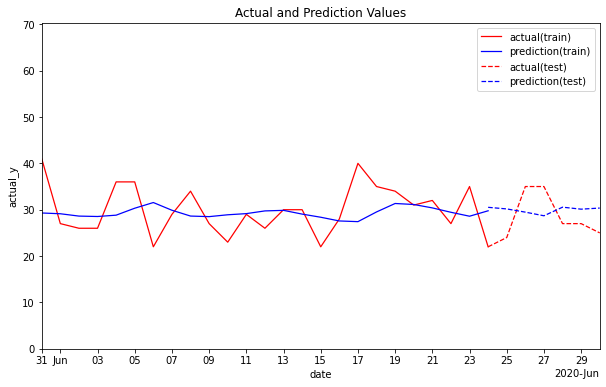

metrics                  Train set                Test set                 
------------------------------------------------------------------
sample size              907                      7                        
RMSE                     7.6408071088155          5.75541003220287         
MAE                      5.893256852073978        5.505355271652753        
MAPE                     24.666791675896473       20.618206620212174       
R-squared                0.0717674334378976       -0.44148533508018706     


In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_SARIMA(train_series, test_series, order, s_order, disp_result= True, return_mse=False,is_hourly=False):
    history = [(float) (x) for x in train_series]       
    predictions = []
    for t in range(len(test_series)): 
        model = SARIMAX(history, order=order, seasonal_order=s_order)
        model_fit = model.fit(cov_type= 'none', low_memory=True)
        output = model_fit.predict(len(history),len(history))
        yhat = output[0]
        predictions.append(yhat)
        obs = test_series[t]
        history.append(obs)
                
        if (disp_result):
            print('date=%s, predicted=%f, expected=%f' % (test_series.keys()[t].strftime("%m/%d/%Y"), yhat, obs))
            
    pred = pd.DataFrame({'date':test_series.keys(), 'actual_y':np.array(test_series),'pred_y': np.array(predictions)})

    model = SARIMAX(np.array(train_series).astype('float'), order=order, seasonal_order=s_order)
    model_fit = model.fit(cov_type= 'none', low_memory=True)
    predictions = model_fit.predict()
    
    train = pd.DataFrame({'date':train_series.keys(), 'actual_y':np.array(train_series),'pred_y': np.array(predictions)})

    if (return_mse):
        mse_tr, _, mape_tr,_ = mean_sa_error(train)
        mse_ts, _, mape_ts, _ = mean_sa_error(pred)
        return mse_tr, mape_tr,mse_ts, mape_ts
    else:
        last_date = np.array(pred['date']).astype('datetime64[D]').max()
        first_date = last_date - np.array(30).astype('timedelta64[D]')
        plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)
        
        if is_hourly:
            train['date'] = np.array(train['date']).astype('datetime64[D]')
            train = train.groupby('date').agg({'actual_y':'sum','pred_y':'sum'}).reset_index()
        
            pred['date'] = np.array(pred['date']).astype('datetime64[D]')
            pred = pred.groupby('date').agg({'actual_y':'sum','pred_y':'sum'}).reset_index()
            plot_results(train, pred, 'date', 'actual_y', 'pred_y',start_date = first_date, end_date = last_date)

train_SARIMA(train_series, test_series,order=(p,d,q),s_order=(0,0,0,91))


2.   *k-fold on SARIMA*

In [ ]:
k=5
n_validation = 7
order=(p,d,q)
s_order=(0,0,0,91)

data_array = train_series.copy()
cut_point = (int)(data_array.shape[0]/k)
data_array = data_array[0:cut_point*k]
for i in range(k):
    train_set = data_array[:(i+1)*cut_point-n_validation]
    validation_set = data_array[(i+1)*cut_point-n_validation:(i+1)*cut_point]  
    mse_tr,mape_tr,mse_ts,mape_ts = train_SARIMA(train_set, validation_set,order, s_order, False, True)
    print('SARIMA fold= %s RMSE=%.3f MAPE=%.3f RMSE(val)=%.3f MAPE(val)=%.3f' % (i+1,mse_tr,mape_tr, mse_ts,mape_ts))


**Deep Learning  Models**

Defined functions

In [59]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, GRU, Bidirectional
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import clone_model
from keras.layers import Input, RepeatVector, TimeDistributed

from keras.layers import ConvLSTM2D



def create_dataset_simple(dataset, n_feature, window_size=14, train_share=0.8, test_share=0):
    """
    it converts an array of values into a dataset matrix and split it into train, validation, and test sets

    Argument:
    dataset -- array of timeseries data
    n_feautre -- number of columns or features each data row has
    window_size -- an integer number showing the number of previous rows considered in modeling
    train_share -- protion of train dataset. Default value is 0.8
    test_share -- portion of test dataset. Default value is 0

    Returns:
    X_train -- array of train x
    Y_train -- array of train y
    X_test -- array of test x
    Y_test -- array of test y
    X_val -- array of validation x
    Y_val -- array of validation y
    
    """ 
    cut_point_1 = int(len(dataset)*train_share)
    cut_point_2 = int(len(dataset)*(train_share+test_share))
    
    y_window_size =1
    
    X_train, Y_train,  X_test, Y_test, X_val, Y_val = [], [], [], [], [], []
    n_f_y = n_feature
    for i in range(0,len(dataset)-window_size-y_window_size):
        x = dataset[i:(i+window_size), :]
        y = dataset[i + window_size:i + window_size+y_window_size,:]
        if(i + window_size<cut_point_1):
            X_train.append(x)
            Y_train.append(y)
        else:
            if(i + window_size<cut_point_2):
                X_test.append(x)
                Y_test.append(y)                               
            else:
                X_val.append(x)
                Y_val.append(y) 
                         

    
    X_train = np.reshape(X_train, (len(X_train), window_size, n_feature))
    X_val = np.reshape(X_val, (len(X_val), window_size, n_feature))
    X_test = np.reshape(X_test, (len(X_test), window_size, n_feature))
            
    Y_train = np.reshape(Y_train, (len(Y_train), y_window_size, n_f_y))
    Y_val = np.reshape(Y_val, (len(Y_val), y_window_size, n_f_y))
    Y_test = np.reshape(Y_test, (len(Y_test), y_window_size, n_f_y))
    
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

def build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val,window_size, n_features, df, y_col=0, sc=False, disp=True, date_col='date_interval'):
    """
    it complies and runs the given deep learning model and plots the results

    Argument:
    model -- keras sequential model
    X_train -- array of train x
    Y_train -- array of train y
    X_test -- array of test x
    Y_test -- array of test y
    X_val -- array of validation x
    Y_val -- array of validation y
    window_size -- an integer number showing the number of previous rows considered in modeling
    n_feautres -- number of columns or features each data row has
    df -- dataframe of input data
    y_col -- column index of response value.  Default value is 0
    sc -- scaler used to scale data. Defaul value is False,
    disp -- a boolean variable to define whether show the keras model output at each epoch. Default value is True, 
    date_col -- the column name data showing the dates. Defualt value is 'date_interval'

    Returns:
    
    
    """
    
    model = clone_model(model)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size = 64, verbose = disp)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'][1:43])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    testPredict = model.predict(X_test)
    
    pred_y = testPredict
    actual_y = Y_test
    
    if sc!=False:
        pred_y = sc.inverse_transform(testPredict)
        actual_y = sc.inverse_transform(Y_test)
      
    dates = df[date_col].values[window_size+len(Y_train):window_size+len(Y_train)+len(pred_y)]
    
    pred = pd.DataFrame({'time':dates, 'actual':np.asarray(actual_y[:,y_col].flatten(), dtype=np.float32), 'pred':np.asarray(pred_y[:,y_col].flatten(), dtype=np.float32)})
    
    trainPredict = model.predict(X_train)
    
    pred_y = trainPredict
    actual_y = Y_train
    
    if sc!=False:
        pred_y = sc.inverse_transform(trainPredict)
        actual_y = sc.inverse_transform(Y_train)
        
    dates = df[date_col].values[window_size:window_size+len(Y_train)]
    train = pd.DataFrame({'time':dates, 'actual':np.asarray(actual_y[:,y_col].flatten(), dtype=np.float32), 'pred':np.asarray(pred_y[:,y_col].flatten(), dtype=np.float32)})
   
    last_date = np.array(pred['time']).astype('datetime64[D]').max()
    first_date = last_date - np.array(30).astype('timedelta64[D]')
    
    plot_results(train,pred, 'time', 'actual','pred',start_date = first_date, end_date = last_date)
    
  
def k_fold_DL_models(model,X_train, Y_train, window_size, y_col,sc, df,date_col = "date_interval", k=5, n_validation = 7):
    """
    it runs k-fold validation on the given deep learning model prints results

    Argument:
    model -- keras sequential model
    X_train -- array of train x
    Y_train -- array of train y
    window_size -- an integer number showing the number of previous rows considered in modeling
    df -- dataframe of input data
    y_col -- column index of response value.
    sc -- scaler used to scale data. Defaul value is False,
    date_col -- the column name data showing the dates. Defualt value is 'date_interval'
    k -- number of folds. default value is 5
    n_validation -- size of validation dataset. default value is 7
    Returns:
    
    
    """
    
    X_array = X_train.copy()
    Y_array = Y_train.copy()
    cut_point = (int)(X_array.shape[0]/k)
    X_array = X_array[0:cut_point*k]
    Y_array = Y_array[0:cut_point*k]
    
    scores = list()
    
    for i in range(k):
        print("Fold No.: %s"% (i+1))
        train_set_x = X_array[:(i+1)*cut_point-n_validation]
        train_set_y = Y_array[:(i+1)*cut_point-n_validation]
        validation_set_x = X_array[(i+1)*cut_point-n_validation:(i+1)*cut_point]
        validation_set_y = Y_array[(i+1)*cut_point-n_validation:(i+1)*cut_point]
        
        
        model = clone_model(model)
        model.compile(optimizer='adam', loss='mse')

        model.fit(train_set_x, train_set_y, epochs=50, batch_size = 256, verbose = False)
    
        testPredict = model.predict(validation_set_x)
    
        pred_y = testPredict
        actual_y = validation_set_y
    
        if sc!=False:
            pred_y = sc.inverse_transform(testPredict)
            actual_y = sc.inverse_transform(validation_set_y)
            
        dates = df[date_col].values[window_size+len(train_set_y):window_size+len(train_set_y)+len(pred_y)]

        pred = pd.DataFrame({'time':dates,'actual':np.asarray(actual_y[:,y_col].flatten(), dtype=np.float32), 'pred':np.asarray(pred_y[:,y_col].flatten(), dtype=np.float32)})
    
        trainPredict = model.predict(train_set_x)
        pred_y = trainPredict
        actual_y = train_set_y
    
        if sc!=False:
            pred_y = sc.inverse_transform(trainPredict)
            actual_y = sc.inverse_transform(train_set_y)
        
        dates = df[date_col].values[window_size:window_size+len(train_set_y)]

        train = pd.DataFrame({'time':dates, 'actual':np.asarray(actual_y[:,y_col].flatten(), dtype=np.float32), 'pred':np.asarray(pred_y[:,y_col].flatten(), dtype=np.float32)})
         
        mse_tr, _, mape_tr,_ = mean_sa_error(train)
        mse_ts, _, mape_ts, _ = mean_sa_error(pred)
        
        scores.append('Deep Learning Model fold= %s RMSE=%.3f MAPE=%.3f RMSE(val)=%.3f MAPE(val)=%.3f' % (i+1,mse_tr,mape_tr, mse_ts,mape_ts))

    for t in scores:
        print(t)
        

Data Preparation

In [60]:
df = pd.read_csv('daily_data.csv')

feature = ['Inbound', 'Outbound', 'Shift']
n_features =len(feature)
y_col = 0
date_col = 'date_interval'

dataset =df[feature].values.reshape(-1, n_features)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

window_size=91*2
test_share = 7/len(df)
validation_share = 91/len(df)
train_share = 1-test_share-validation_share

X_train, Y_train, X_test, Y_test, X_val, Y_val = create_dataset_simple(dataset, n_features, window_size, train_share, test_share)

Y_train = Y_train.reshape((Y_train.shape[0], n_features))
Y_test = Y_test.reshape((Y_test.shape[0], n_features))
Y_val = Y_val.reshape((Y_val.shape[0], n_features))

Vanila LSTM

1.   *Model Structure*
2.   *Train the model*
3.   *k-fold on the Model*

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               163200    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 603       
Total params: 163,803
Trainable params: 163,803
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 8s 594ms/step - loss: 0.1656 - accuracy: 0.6217 - val_loss: 0.0168 - val_accuracy: 0.7556
Epoch 2/50
10/10 [==============================] - 5s 530ms/step - loss: 0.0417 - accuracy: 0.7322 - val_loss: 0.0517 - val_accuracy: 0.7556
Epoch 3/50
10/10 [==============================] - 5s 537ms/step - loss: 0.0679 - accuracy: 0.6923 - val_loss: 0.0276 - val_accuracy: 0.7556
Epoch 4/50
10/10 [==============================] - 5s 523ms/step - loss: 0.0278 - a

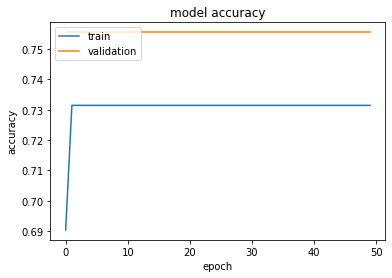

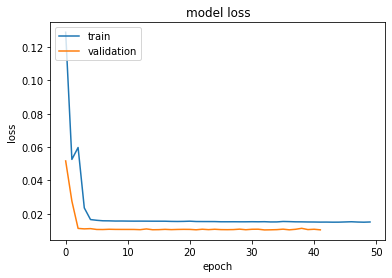

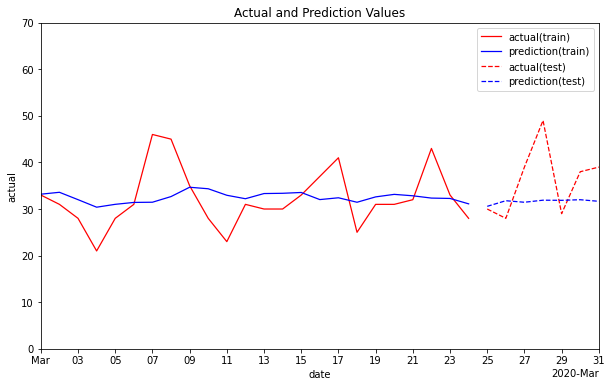

metrics                  Train set                Test set                 
------------------------------------------------------------------
sample size              633                      7                        
RMSE                     7.183996200561523        8.127742767333984        
MAE                      5.509354591369629        6.460805416107178        
MAPE                     19.302736222743988       16.314496099948883       
R-squared                0.14112567901611328      -0.360062837600708       
Fold No.: 1
Fold No.: 2
Fold No.: 3
Fold No.: 4
Fold No.: 5
Deep Learning Model fold= 1 RMSE=6.630 MAPE=18.181 RMSE(val)=4.558 MAPE(val)=11.799
Deep Learning Model fold= 2 RMSE=7.489 MAPE=22.096 RMSE(val)=9.512 MAPE(val)=22.251
Deep Learning Model fold= 3 RMSE=7.899 MAPE=20.884 RMSE(val)=6.761 MAPE(val)=25.836
Deep Learning Model fold= 4 RMSE=7.468 MAPE=20.242 RMSE(val)=5.361 MAPE(val)=17.298
Deep Learning Model fold= 5 RMSE=7.315 MAPE=19.919 RMSE(val)=4.692 MAPE(val)=11.1

In [61]:
n_unit = 200

model = Sequential()
model.add(LSTM(n_unit, activation='relu', input_shape=(window_size, n_features)))
model.add(Dense(n_features))
model.summary()

build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val,window_size,  n_features, df,y_col,scaler, disp=True)
k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)


Stacked LSTM

In [ ]:
n_unit = 200

model = Sequential()
model.add(LSTM(n_unit, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
model.add(LSTM(n_unit, activation='relu'))
model.add(Dense(n_features))
model.summary()    

build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val, window_size,n_features, df,y_col,scaler, disp=False)

k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)

Bidirectional LSTM

In [ ]:
n_unit = 200

model = Sequential()
model.add(Bidirectional(LSTM(n_unit, activation='relu'), input_shape=(window_size, n_features)))
model.add(Dense(n_features))
model.summary() 

build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val, window_size,n_features, df,y_col,scaler, disp=False)

k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)


Stacked Bidirectional LSTM

In [ ]:
n_unit =100

model = Sequential()
model.add(Bidirectional(LSTM(n_unit, activation='relu',return_sequences=True), input_shape=(window_size, n_features)))
model.add(LSTM(n_unit, activation='relu'))
model.add(Dense(n_features))
model.summary() 

build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val, window_size,n_features, df,y_col,scaler, disp=False)

k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)


Stacked Autoencoder (SAE)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3, 150)            27450     
_________________________________________________________________
activation (Activation)      (None, 3, 150)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 3, 150)            22650     
_________________________________________________________________
activation_1 (Activation)    (None, 3, 150)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 3, 150)            22650     
_________________________________________________________________
activation_2 (Activation)    (None, 3, 150)            0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 150)           

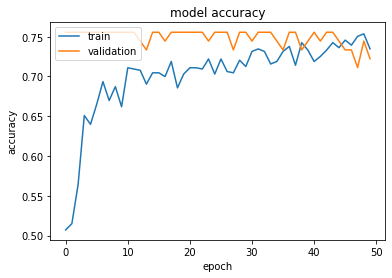

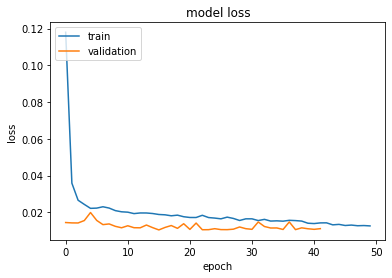

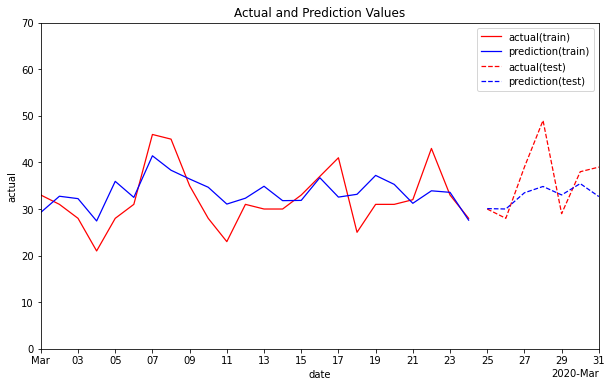

metrics                  Train set                Test set                 
------------------------------------------------------------------
sample size              633                      7                        
RMSE                     6.091560363769531        6.5198974609375          
MAE                      4.776622772216797        4.950974464416504        
MAPE                     17.638948559761047       12.467020004987717       
R-squared                0.38247501850128174      0.1248134970664978       
Fold No.: 1
Fold No.: 2
Fold No.: 3
Fold No.: 4
Fold No.: 5
Deep Learning Model fold= 1 RMSE=5.353 MAPE=14.188 RMSE(val)=5.369 MAPE(val)=14.472
Deep Learning Model fold= 2 RMSE=6.951 MAPE=19.655 RMSE(val)=14.418 MAPE(val)=26.327
Deep Learning Model fold= 3 RMSE=6.780 MAPE=18.432 RMSE(val)=8.806 MAPE(val)=33.912
Deep Learning Model fold= 4 RMSE=7.065 MAPE=18.584 RMSE(val)=5.189 MAPE(val)=16.611
Deep Learning Model fold= 5 RMSE=7.533 MAPE=19.820 RMSE(val)=6.280 MAPE(val)=13.

In [57]:
n_unit=150

model = Sequential()
model.add(Dense(units=n_unit, batch_input_shape=(None,n_features, window_size)))
model.add(Activation(activation='relu'))
model.add(Dense(units=n_unit))
model.add(Activation(activation='tanh'))
model.add(Dense(units=n_unit))
model.add(Activation(activation='relu'))
model.add(Dropout(rate= 0.3))
model.add(Flatten())
model.add(Dense(units=n_features))
model.summary()

X_train = X_train.reshape((X_train.shape[0], n_features, window_size))
X_test = X_test.reshape((X_test.shape[0], n_features, window_size))
X_val = X_val.reshape((X_val.shape[0], n_features, window_size))
    
Y_train = Y_train.reshape((Y_train.shape[0], n_features))
Y_test = Y_test.reshape((Y_test.shape[0], n_features))
Y_val = Y_val.reshape((Y_val.shape[0], n_features))
    
build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val,window_size, n_features, df,y_col,scaler, disp=False)
k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)


Gate Recurrent Unit (GRU)

In [ ]:
n_unit=200

model = Sequential()
model.add(GRU(units=n_unit, input_shape=(window_size,n_features), return_sequences=True, activation='relu', recurrent_activation= 'hard_sigmoid'))
model.add(GRU(units=n_unit, input_shape=(window_size,n_features),  return_sequences=False, activation='relu'))
model.add(Dropout(rate= 0.2))
model.add(Dense(units= n_features, activation= 'relu'))
model.summary()

X_train = X_train.reshape((X_train.shape[0], window_size,n_features))
X_test = X_test.reshape((X_test.shape[0], window_size,n_features))
X_val = X_val.reshape((X_val.shape[0], window_size,n_features))
    
Y_train = Y_train.reshape((Y_train.shape[0], n_features))
Y_test = Y_test.reshape((Y_test.shape[0], n_features))
Y_val = Y_val.reshape((Y_val.shape[0], n_features))
    
build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val, window_size,n_features, df,y_col,scaler, disp=False)
k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)

**Hybrid Deep Learning Models**
Stacked LSTM Encoder

In [ ]:
n_unit =200
n_future=28

model = Sequential()
model.add(Input(shape=(window_size, n_features)))
model.add(LSTM(n_unit, activation='relu', return_sequences = True))
model.add(LSTM(n_unit, activation='relu'))
model.add(RepeatVector(n_future))
model.add(LSTM(n_unit, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.add(LSTM(n_features))
model.summary()

X_train = X_train.reshape((X_train.shape[0], window_size,n_features))
X_test = X_test.reshape((X_test.shape[0], window_size,n_features))
X_val = X_val.reshape((X_val.shape[0], window_size,n_features))
   
Y_train = Y_train.reshape((Y_train.shape[0], n_features))
Y_test = Y_test.reshape((Y_test.shape[0], n_features))
Y_val = Y_val.reshape((Y_val.shape[0], n_features))

build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val,window_size, n_features, df,y_col,scaler, disp=False)

k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)


CNN LSTM

In [ ]:
n_seq = 7
new_window_size = (int)(window_size/n_seq)
n_unit =200

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, new_window_size, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(n_unit, activation='relu'))
model.add(Dense(n_features))
model.summary()


X_train = X_train.reshape((X_train.shape[0], n_seq, new_window_size, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, new_window_size, n_features))
X_val = X_val.reshape((X_val.shape[0], n_seq, new_window_size, n_features))
    
Y_train = Y_train.reshape((Y_train.shape[0], n_features))
Y_test = Y_test.reshape((Y_test.shape[0], n_features))
Y_val = Y_val.reshape((Y_val.shape[0], n_features))
    
    
build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val,window_size, n_features, df,y_col,scaler, disp=False)

k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)

ConvLSTM

In [ ]:
n_seq = 7
n_row = 2
new_window_size = (int)(window_size/n_seq/n_row)
n_unit =200

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, n_row, new_window_size, n_features)))
model.add(Flatten())
model.add(Dense(n_features))
model.summary()

X_train = X_train.reshape((X_train.shape[0], n_seq, n_row, new_window_size, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_row, new_window_size, n_features))
X_val = X_val.reshape((X_val.shape[0], n_seq, n_row, new_window_size, n_features))
    
Y_train = Y_train.reshape((Y_train.shape[0], n_features))
Y_test = Y_test.reshape((Y_test.shape[0], n_features))
Y_val = Y_val.reshape((Y_val.shape[0], n_features))
    
build_run_simple(model, X_train, Y_train, X_test, Y_test, X_val, Y_val,window_size, n_features, df,y_col,scaler, disp=False)
k_fold_DL_models(model,X_train, Y_train, window_size, y_col,scaler, df)
